In [2]:
import json
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import numpy as np
from eval import embedding
from sklearn.decomposition import PCA
from scipy.linalg import svd
from scipy.spatial import distance
from numpy.linalg import norm

# WEAT results

In [3]:
all_res = pd.read_json('../results/out.json', orient='index')

scores = all_res.applymap(lambda e: e['score'])
scores

,Science_Arts_Male_Female,Math_Arts_Male_Female,Flowers_Insects_Pleasant_Unpleasant
cpae,0.821287,1.361192,0.994084
d2v,0.779212,1.398340,1.364604
glove,1.380025,1.384579,1.393896
w2v,1.195150,1.104706,1.554976


<AxesSubplot:>

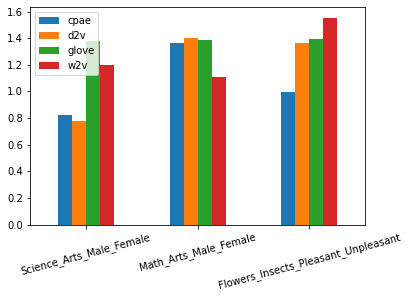

In [4]:
scores.T.plot(kind='bar', rot=15)

<AxesSubplot:>

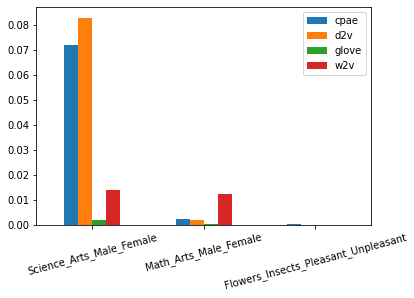

In [5]:
p_vals = all_res.applymap(lambda e: e['p_val'])
p_vals.T.plot(kind='bar', rot=15)

# Embedding Analysis

## Projections

In [14]:
with open('../results/weat.json') as fin:
    weat_words = json.load(fin)

math_male = set(weat_words['Math_Arts_Male_Female']['Male attributes'])
science_male = set(weat_words['Science_Arts_Male_Female']['Male attributes'])
male_words = math_male.union(science_male)

math_female = set(weat_words['Math_Arts_Male_Female']['Female attributes'])
science_female = set(weat_words['Science_Arts_Male_Female']['Female attributes'])
female_words = math_female.union(science_female) 

math_arts = set(weat_words['Math_Arts_Male_Female']['Arts Words'])
science_arts = set(weat_words['Science_Arts_Male_Female']['Arts words'])
arts_words = math_arts.union(science_arts)
science_words = set(weat_words['Science_Arts_Male_Female']['Science words'])
math_words = set(weat_words['Math_Arts_Male_Female']['Math words'])

female_words.remove('hers')
math_female.remove('hers')
science_female.remove('hers')

word_lists = {
    'male': male_words,
    'math': math_words,
    'science': science_words,
    'arts': arts_words,
    'female': female_words,
    'm1': math_male,
    'm2': science_male,
    'f1': math_female,
    'f2': science_female,
    'a1': math_arts,
    'a2': science_arts,
}
print(word_lists)

{'male': {'man', 'son', 'male', 'uncle', 'his', 'father', 'grandfather', 'him', 'boy', 'brother', 'he'}, 'math': {'calculus', 'equations', 'addition', 'numbers', 'computation', 'algebra', 'math', 'geometry'}, 'science': {'experiment', 'chemistry', 'astronomy', 'technology', 'science', 'physics', 'biology'}, 'arts': {'literature', 'art', 'symphony', 'poetry', 'drama', 'novel', 'sculpture', 'dance'}, 'female': {'woman', 'her', 'grandmother', 'sister', 'mother', 'daughter', 'she', 'female', 'aunt', 'girl'}, 'm1': {'man', 'son', 'male', 'his', 'him', 'boy', 'brother', 'he'}, 'm2': {'son', 'uncle', 'father', 'his', 'him', 'grandfather', 'brother', 'he'}, 'f1': {'woman', 'her', 'sister', 'daughter', 'she', 'female', 'girl'}, 'f2': {'her', 'grandmother', 'sister', 'mother', 'daughter', 'she', 'aunt'}, 'a1': {'literature', 'art', 'symphony', 'poetry', 'drama', 'novel', 'sculpture', 'dance'}, 'a2': {'literature', 'art', 'symphony', 'poetry', 'drama', 'novel', 'dance'}}


In [17]:
def get_embed_plot(the_embeds, hlines=(-1.5, 1.5)):
    def ave_vec(embeds, words):
        ave = np.zeros((300,))
        for word in words:
            ave += embeds[word]
        return ave / len(words)

    male_ave = ave_vec(the_embeds, male_words)
    female_ave = ave_vec(the_embeds, female_words)

    diff = female_ave - male_ave
    diff_norm = diff / norm(diff)
    
    def project(embeds, words):
        return {word: np.dot(embeds[word], diff_norm) / norm(embeds[word]) for word in words}

    word_sims = {k: project(the_embeds, v) for k, v in word_lists.items()}
    
    plt.figure(figsize=(20,5))
    plt.vlines(0, 0, 10, color='gray')
    colors = ['lightgray', 'green', 'blue', 'red', 'tan']
    for i, (k, v) in enumerate(word_sims.items()):
        if i >= len(colors):
            break
        height = 9-2*i
        plt.eventplot(v.values(), orientation='horizontal', colors=colors[i], label=k, lw=3, lineoffset=height)
        for word, x_val in sorted(v.items(), key=lambda kv: -kv[1]):
            plt.annotate(word, xy=(x_val, height+.5), rotation=45, bbox=dict(boxstyle='round', fc='white', ec='lightblue'))
    plt.yticks([])
    
    plt.legend()
    plt.show()

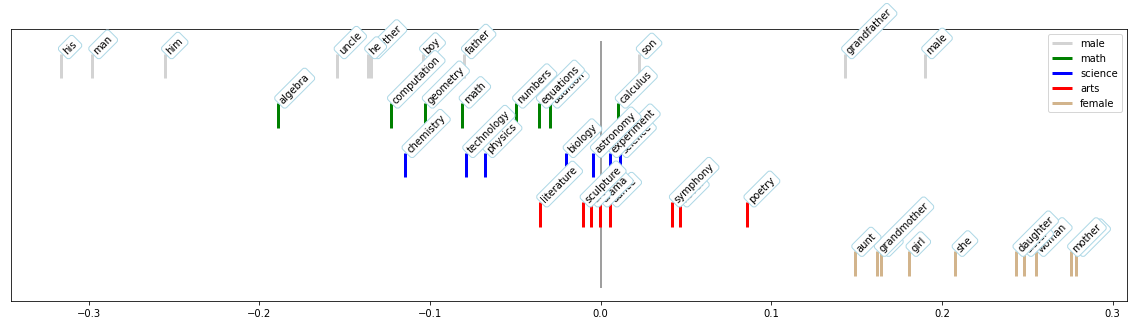

In [18]:
cpae_embeds = embedding.EmbedCpae().get_gs()
get_embed_plot(cpae_embeds, hlines=(-.6, .6))

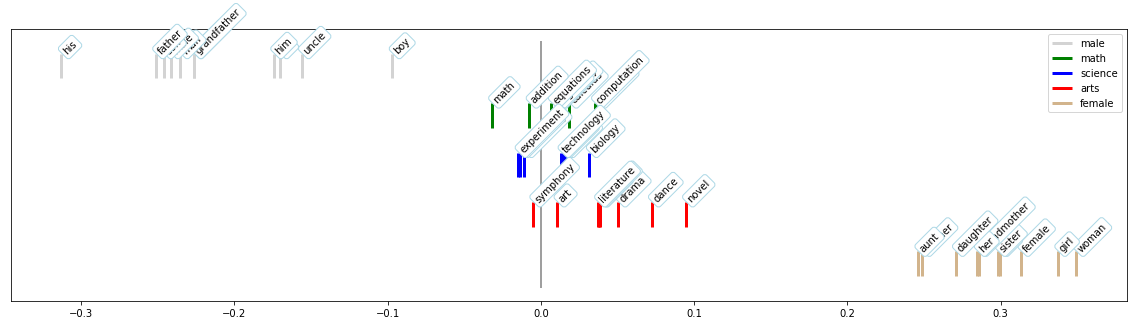

In [19]:
d2v_embeds = embedding.EmbedDict2V().get_gs()
get_embed_plot(d2v_embeds, hlines=(-.25, .5))

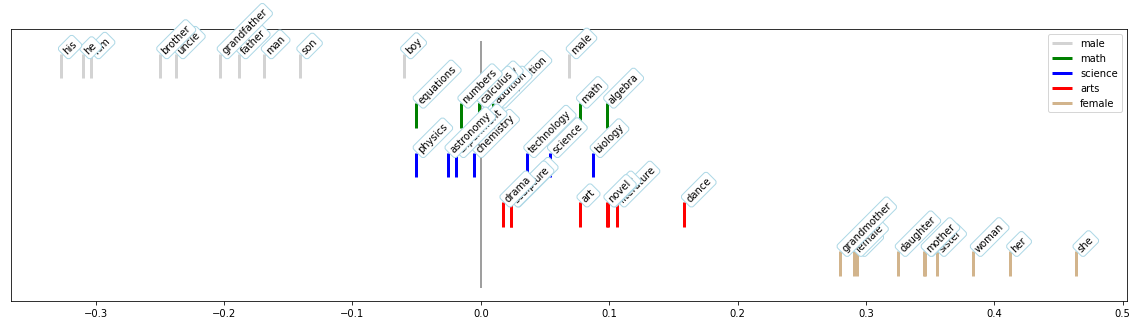

In [20]:
w2v_embeds = embedding.EmbedWord2V().get_gs()
get_embed_plot(w2v_embeds, hlines=(-.1, .2))

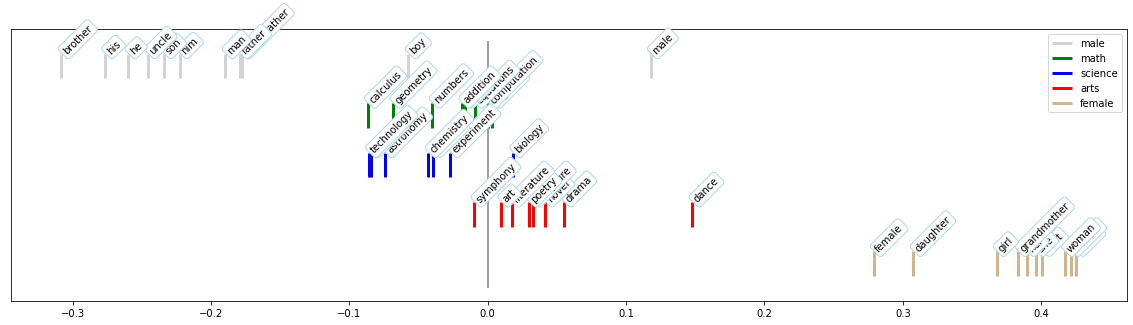

In [21]:
glove_embeds = embedding.EmbedGlove().get_gs()
get_embed_plot(glove_embeds, hlines=(-1,1.2))

## PCA for "gender"

In [22]:
diff_pairs = [
    ('she', 'he'),
    ('her', 'his'),
    ('woman', 'man'),
    ('herself', 'himself'),
    ('daughter', 'son'),
    ('mother', 'father'),
    ('gal', 'guy'),
    ('girl', 'boy'),
    ('female', 'male')
]

In [23]:
def get_svd(embeds, diff_pairs):
    m = np.zeros((len(diff_pairs),300))
    for i, (w1, w2) in enumerate(diff_pairs):
        m[i] = embeds[w1] - embeds[w2]
    return svd(m)

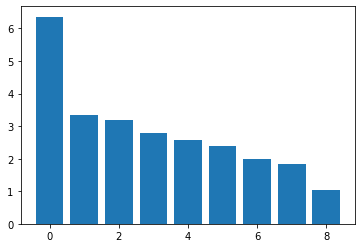

In [24]:
U, s, Vh = get_svd(cpae_embeds, diff_pairs)
plt.bar(np.arange(len(s)), s)
plt.show()

In [25]:
print(Vh)

[[-1.84528583e-02 -2.98114987e-03  4.94741188e-03 ...  8.18804659e-03
  -1.80349954e-03  7.42098441e-02]
 [ 1.20749454e-02 -2.83568488e-02 -2.75665836e-02 ...  9.29339398e-03
   2.79338979e-02  6.98032436e-02]
 [-6.67812926e-02  6.34193855e-02 -1.03683006e-01 ...  7.21812435e-02
  -7.93805963e-02 -3.35495475e-02]
 ...
 [-8.94927205e-03 -3.33104356e-02  3.20865674e-02 ...  9.75368397e-01
   3.14123966e-03  1.05614446e-02]
 [-5.84158565e-02 -6.66098032e-02 -1.04400562e-02 ...  4.17041262e-03
   9.64321751e-01 -8.68610506e-04]
 [ 1.92703081e-02  1.44346322e-02  4.07514594e-02 ...  1.32951449e-02
   1.17636744e-03  9.81200718e-01]]


<BarContainer object of 10 artists>

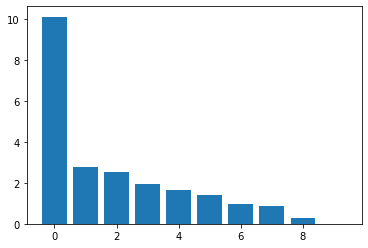

In [26]:
def weird_svd(embeds, diff_pairs):
    m = np.zeros((300, 300))
    for w1, w2 in diff_pairs:
        w_1, w_2 = embeds[w1], embeds[w2]
        mu = (w_1 + w_2) / 2
        partial = ((w_1 - mu).reshape(-1,1) * (w_1 - mu).reshape(1,-1) \
                   + (w_2 - mu).reshape(-1, 1) * (w_2 - mu).reshape(1, -1)) / 2
        m += partial
    return svd(m)
U, s, Vh = weird_svd(cpae_embeds, diff_pairs)
plt.bar(np.arange(10), s[:10])

In [27]:
print(distance.cosine(U[0], cpae_embeds['she'] - cpae_embeds['he']))

0.9892112766866141


# Dictionary Investigation

In [28]:
# lists so we can map between the two
f_list = [a[0] for a in diff_pairs]
m_list = [a[1] for a in diff_pairs]

In [29]:
with open('../cpae/data/en_wn_full/all.json', 'r') as f:
    en_full = json.load(f)
assert([len(v) == 1 for v in en_full.values()])
en_full = {k: v[0] for k,v in en_full.items()}

## Graph-like Connections

In [85]:
dp = {}
def num_connections(word1, word2, max_dist=1):
    if tuple([word1, word2, max_dist]) in dp:
        return dp[(word1, word2, max_dist)]
    
    if max_dist == 0:
        return 1 if word1 == word2 else 0
    total = 0
    for neighbor in en_full.get(word1, []):
        total += num_connections(neighbor, word2, max_dist-1)
    
    dp[(word1, word2, max_dist)] = total
    return total

In [86]:
def conn_matrix(list1, list2, depth=3):
    to_ret = {}
    for i in list1:
        to_ret[i] = {}
        for j in list2:
            to_ret[i][j] = num_connections(i, j, depth)
    return to_ret

In [87]:
mm = conn_matrix(word_lists['math'], word_lists['m1'])
mm = pd.DataFrame.from_dict(mm)
mm

,calculus,equations,addition,numbers,computation,algebra,math,geometry
man,2,0,6,37,4,0,8,0
son,0,0,2,0,0,0,0,0
male,6,0,3,26,3,0,3,0
his,1,0,5,18,1,2,1,0
him,4,0,6,21,1,2,0,0
boy,0,0,0,0,0,0,0,0
brother,0,0,1,0,0,0,0,0
he,1,0,1,3,0,0,2,1


In [88]:
mf = conn_matrix(word_lists['math'], word_lists['f1'])
mf = pd.DataFrame.from_dict(mf)
mf

,calculus,equations,addition,numbers,computation,algebra,math,geometry
woman,1,0,2,18,2,0,3,0
her,1,0,0,2,0,0,2,1
sister,0,0,1,0,0,0,0,0
daughter,0,0,0,0,0,0,0,0
she,0,0,1,1,0,0,2,0
female,2,0,1,4,0,0,0,0
girl,0,0,0,1,0,0,0,0


In [89]:
am1 = conn_matrix(word_lists['a1'], word_lists['m1'])
am1 = pd.DataFrame.from_dict(am)
am1 

,literature,art,symphony,poetry,drama,novel,sculpture,dance
man,5,7,1,5,3,3,7,8
son,0,0,0,0,0,0,0,0
male,8,1,0,2,0,5,9,7
his,6,3,0,2,1,7,3,7
him,4,3,0,1,4,10,4,5
boy,0,0,0,0,0,0,0,0
brother,0,0,0,0,0,0,0,0
he,3,0,0,0,3,3,5,2


In [90]:
af1 = conn_matrix(word_lists['a1'], word_lists['f1'])
af1 = pd.DataFrame.from_dict(af)
af1 

,literature,art,symphony,poetry,drama,novel,sculpture,dance
woman,2,2,2,1,3,2,0,11
her,1,0,1,0,4,0,3,2
sister,0,0,0,0,0,0,0,0
daughter,0,0,0,0,0,0,0,0
she,1,0,0,0,0,2,2,0
female,7,0,0,3,0,4,0,4
girl,0,0,0,0,0,0,0,0


In [91]:
sm = conn_matrix(word_lists['science'], word_lists['m2'])
sm = pd.DataFrame.from_dict(sm)
sm

,experiment,chemistry,astronomy,technology,science,physics,biology
son,0,0,0,0,0,0,0
uncle,0,0,0,0,0,0,0
father,0,0,0,0,0,0,0
his,11,2,1,4,0,1,0
him,1,0,1,2,0,2,0
grandfather,0,0,0,0,0,0,0
brother,0,0,0,0,0,0,0
he,1,4,0,6,0,0,0


In [92]:
sf = conn_matrix(word_lists['science'], word_lists['f2'])
sf = pd.DataFrame.from_dict(sf)
sf

,experiment,chemistry,astronomy,technology,science,physics,biology
her,1,3,1,5,0,0,0
grandmother,0,0,0,0,0,0,0
sister,0,0,0,0,0,0,0
mother,0,0,0,0,0,0,0
daughter,0,0,0,0,0,0,0
she,0,4,0,2,0,0,0
aunt,0,0,0,0,0,0,0


In [93]:
am2 = conn_matrix(word_lists['a2'], word_lists['m2'])
am2 = pd.DataFrame.from_dict(a2m)
am2

,literature,art,symphony,poetry,drama,novel,dance
son,0,0,0,0,0,0,0
uncle,0,0,0,0,0,0,0
father,2,2,0,0,0,0,0
his,6,3,0,2,1,7,7
him,4,3,0,1,4,10,5
grandfather,0,0,0,0,0,0,0
brother,0,0,0,0,0,0,0
he,3,0,0,0,3,3,2


In [94]:
af2 = conn_matrix(word_lists['a2'], word_lists['f2'])
af2 = pd.DataFrame.from_dict(a2f)
af2

,literature,art,symphony,poetry,drama,novel,dance
her,1,0,1,0,4,0,2
grandmother,0,0,0,0,0,0,0
sister,0,0,0,0,0,0,0
mother,0,0,0,0,0,0,0
daughter,0,0,0,0,0,0,0
she,1,0,0,0,0,2,0
aunt,0,0,0,0,0,0,0


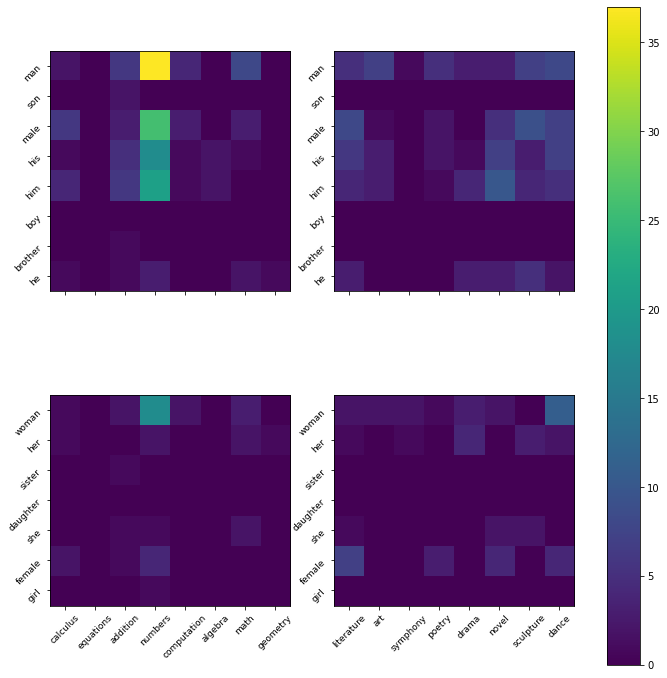

In [95]:
smallest = 0
largest1 = max(mm.to_numpy().max(), mf.to_numpy().max(), am1.to_numpy().max(), af1.to_numpy().max())
norm1 = matplotlib.colors.Normalize(vmin=smallest, vmax=largest1)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(10,10), nrows=2, ncols=2)

ax1.get_shared_x_axes().join(ax1, ax3)
ax1.set_xticks(np.arange(len(word_lists['math'])))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(len(word_lists['m1'])))
ax1.set_yticklabels(word_lists['m1'], rotation=45, fontsize=9)

ax3.set_xticks(np.arange(len(word_lists['math'])))
ax3.set_xticklabels(word_lists['math'], rotation=45, fontsize=9)
ax3.set_yticks(np.arange(len(word_lists['f1'])))
ax3.set_yticklabels(word_lists['f1'], rotation=45, fontsize=9)


ax2.get_shared_x_axes().join(ax2, ax4)
ax2.set_xticks(np.arange(len(word_lists['a1'])))
ax2.set_xticklabels([])
ax2.set_yticks(np.arange(len(word_lists['m1'])))
ax2.set_yticklabels(word_lists['m1'], rotation=45, fontsize=9)

ax4.set_xticks(np.arange(len(word_lists['a1'])))
ax4.set_xticklabels(word_lists['a1'], rotation=45, fontsize=9)
ax4.set_yticks(np.arange(len(word_lists['f1'])))
ax4.set_yticklabels(word_lists['f1'], rotation=45, fontsize=9)

pos = ax1.imshow(mm, norm=norm1)
# fig.colorbar(pos, ax=ax1)
pos = ax3.imshow(mf, norm=norm1)
pos = ax2.imshow(am1, norm=norm1)
# fig.colorbar(pos, ax=ax1)
pos = ax4.imshow(af1, norm=norm1)

fig.subplots_adjust(wspace=0.01, hspace=0.01)

fig.tight_layout()

fig.colorbar(pos, ax=[ax1, ax2, ax3, ax4])

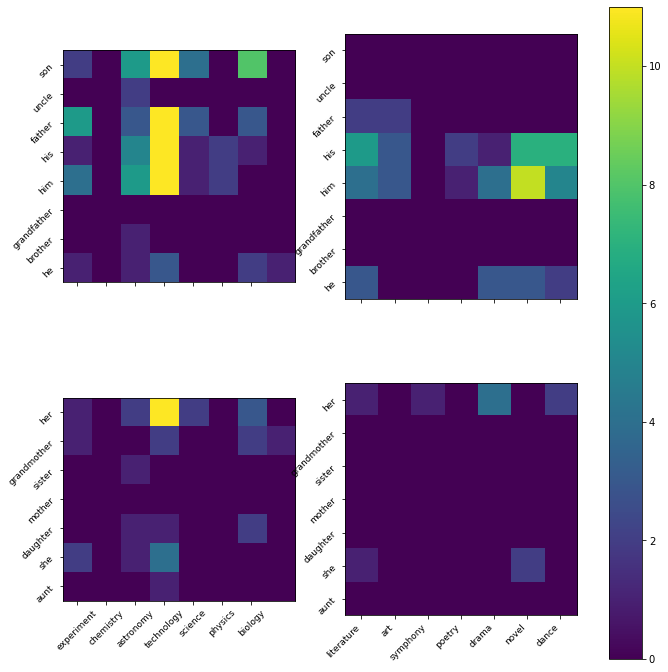

In [96]:
smallest = 0
largest1 = max(sm.to_numpy().max(), sf.to_numpy().max(), am2.to_numpy().max(), af2.to_numpy().max())
norm1 = matplotlib.colors.Normalize(vmin=smallest, vmax=largest1)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(10,10), nrows=2, ncols=2)

ax1.get_shared_x_axes().join(ax1, ax3)
ax1.set_xticks(np.arange(len(word_lists['science'])))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(len(word_lists['m2'])))
ax1.set_yticklabels(word_lists['m2'], rotation=45, fontsize=9)

ax3.set_xticks(np.arange(len(word_lists['science'])))
ax3.set_xticklabels(word_lists['science'], rotation=45, fontsize=9)
ax3.set_yticks(np.arange(len(word_lists['f2'])))
ax3.set_yticklabels(word_lists['f2'], rotation=45, fontsize=9)


ax2.get_shared_x_axes().join(ax2, ax4)
ax2.set_xticks(np.arange(len(word_lists['a2'])))
ax2.set_xticklabels([])
ax2.set_yticks(np.arange(len(word_lists['m2'])))
ax2.set_yticklabels(word_lists['m2'], rotation=45, fontsize=9)

ax4.set_xticks(np.arange(len(word_lists['a2'])))
ax4.set_xticklabels(word_lists['a2'], rotation=45, fontsize=9, ha='right')
ax4.set_yticks(np.arange(len(word_lists['f2'])))
ax4.set_yticklabels(word_lists['f2'], rotation=45, fontsize=9)

pos = ax1.imshow(mm, norm=norm1)
# fig.colorbar(pos, ax=ax1)
pos = ax3.imshow(mf, norm=norm1)
pos = ax2.imshow(am2, norm=norm1)
# fig.colorbar(pos, ax=ax1)
pos = ax4.imshow(af2, norm=norm1)

fig.subplots_adjust(wspace=0.01, hspace=0.01)

fig.tight_layout()

fig.colorbar(pos, ax=[ax1, ax2, ax3, ax4])

## Co-Occurrence

In [ ]:
def cooccur(list_pairs):
    cos = [{} for _ in list_pairs]
    for v in en_full.values():
        v_s = set(v)
        for i, (l1, l2) in enumerate(list_pairs):
            for w1 in l1:
                if w1 not in cos[i]: cos[i][w1] = {}
                for w2 in l2:
                    if w2 not in cos[i][w1]: cos[i][w1][w2] = 0
                    if w1 in v_s and w2 in v_s:
                        cos[i][w1][w2] += 1
    return cos

plt.imshow(pd.DataFrame.from_dict(cooccur([(word_lists['math'], word_lists['m1'])])[0]))